In [ ]:
# Team Deep Divers submission for
# Brown Data Science DATA2040 Deep Learning course. 
# Authors: Haoda Song, Siyuan Li, Yuyang Li

# The Kaggle notebook structure is based on the example created by Kaiwen Yang and Dr.Dan Potter
# The simple version is used for Kaggle post 
# So the full version could be shown as the private python notebook which submitted to the team google drive.

import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
import json
import tensorflow as tf
from functools import partial

import tensorflow.keras as keras
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_labels = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')

In [ ]:
### https://www.kaggle.com/grantwiersum/cassava-disease-tfrecord-training
import glob
csv_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
train_dir = '/kaggle/input/cassava-leaf-disease-classification/train_tfrecords/*'
test_dir = '/kaggle/input/cassava-leaf-disease-classification/test_tfrecords/*'
train_list = glob.glob(train_dir)
test_list = glob.glob(test_dir)
print("train: " + str(len(train_list)) + "\ntest: " + str(len(test_list)))

In [ ]:
labels = train_labels
labels.head()

In [ ]:
labels['label']=labels['label'].astype(str)

In [ ]:
with open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
  disease_dict = json.load(f)
disease_df = pd.DataFrame(list(disease_dict.items()),columns = ['label','real_label'])

for i in range(len(disease_df)):
  disease_df['label'][i] = int(i)

actual_class = pd.merge(csv_df,disease_df,on='label') 
#Count the number of images in each disease
obs_in_actual = actual_class.groupby(['label','real_label']).size()
print(obs_in_actual) 

In [ ]:
ax = (actual_class.value_counts(actual_class['real_label'], ascending=True)
                 .plot(kind='barh', fontsize="20", 
                       title="Class Distribution", figsize=(8,5)))

ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.title.set_size(15)
plt.show()

# Image Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./225,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.3,
    horizontal_flip=True,)


test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = '/kaggle/input/cassava-leaf-disease-classification/train_images/'

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=train_dir,
      subset='training',
      x_col="image_id",
      y_col="label",
      shuffle=True,
      target_size=(96,96),
      batch_size=64,
      class_mode='categorical')

valid_generator = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=train_dir,
      subset='validation',
      x_col="image_id",
      y_col="label",
      shuffle=True,
      target_size=(96,96),
      batch_size=64,
      class_mode='categorical')

In [ ]:
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D,BatchNormalization, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random

# Baseline CNN Model

In [ ]:
def build_baseline():
    inputs = Input(shape = (96,96,3))
    
    model = Conv2D(filters=32, kernel_size=(3, 3),activation='relu', kernel_initializer='he_normal',
                   input_shape=(96,96,3))(inputs)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    
    model = Flatten()(model)
    model = Dense(384, activation = "relu")(model)
    out = Dense(5, activation = 'softmax')(model)
    model = Model(inputs=inputs, outputs=out)
    
    model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['acc'])
    return model

In [ ]:
model = build_baseline()
print(model.summary())

In [ ]:
!rm -rf ./logs
!mkdir ./logs/
!mkdir ./logs/data2040_midterm_project

log_dir="./logs/data2040_midterm_project/"
def tensorboard_callback(exp_name):
  return tf.keras.callbacks.TensorBoard(log_dir=log_dir + exp_name, profile_batch=0, histogram_freq=1)
# launch tensorboard with specific directory
%reload_ext tensorboard
%tensorboard --logdir logs/data2040_midterm_project

In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch = 20,
    validation_steps= 20,
    validation_data = valid_generator, 
    epochs = 100, 
    callbacks = [tensorboard_callback('data2040_midterm_project')],
    verbose = 1
)

The above training process shows a sample. However, the baseline model could achieve around 0.73 validation accuracy rate if we train 50 epochs and set more steps per epoch as the plot belowing shows.

In [ ]:
#Do Not Run: The code only fits when the number of epochs achieved 50.
import matplotlib.pyplot as plt
#N = 50
#plt.style.use("ggplot")
#plt.figure()
#plt.plot(np.arange(0, N), history.history["acc"], label="Train Accuracy")
#plt.plot(np.arange(0, N), history.history["val_acc"], label="Validation Accuracy")
#plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
#plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
#plt.title("Loss and Accuracy Plot")
#plt.xlabel("Epoch")
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

Baseline(50).png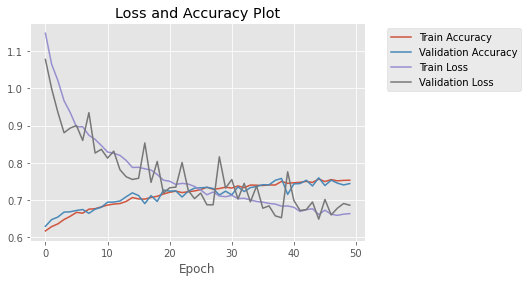

# EfficientNetB4

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
effb4_model = tf.keras.Sequential()

effb4_model.add(EfficientNetB4(include_top = False, weights = None,
                          input_shape = (96, 96, 3)))

effb4_model.add(tf.keras.layers.GlobalAveragePooling2D())
effb4_model.add(tf.keras.layers.Dense(5, activation = "softmax"))

effb4_model.compile(optimizer = Adam(lr = 0.01),
              loss = "categorical_crossentropy",
              metrics = ["acc"])

In [ ]:
effb4_model.summary()

In [ ]:
history_effb4 = effb4_model.fit(training_set,
                                validation_data=testing_set, steps_per_epoch= len(X_train)//BATCH_SIZE, epochs=200, 
                                callbacks = [tensorboard_callback('projects-efficientnet')])

In [ ]:
import matplotlib.pyplot as plt

N = 200
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_effb4.history["acc"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_effb4.history["val_acc"], label="Validation Accuracy")
plt.plot(np.arange(0, N), history_effb4.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_effb4.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

# ResNet

In [ ]:
!pip install d2l==0.16.1
from d2l import tensorflow as d2l
import tensorflow as tf

class Residual(tf.keras.Model):  #@save
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [ ]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [ ]:
res101 = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(96,96,3)),
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=5, activation="softmax")])

In [ ]:
res101.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(lr=0.0005),
          metrics=['acc'])
history_res = res101.fit(
    training_set, 
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_data = testing_set, 
    epochs = 100, 
    callbacks = tensorboard_callback('projects-ResNet'),
    verbose = 1)

In [ ]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_res.history["acc"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_res.history["val_acc"], label="Validation Accuracy")
plt.plot(np.arange(0, N), history_res.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_res.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ResNet1.png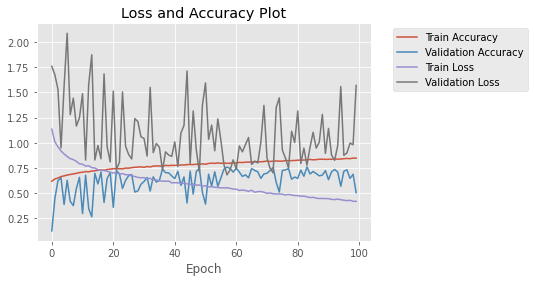

# Self Designed VGGNet

In [ ]:
# The self-designed model is generated based on the combination of convolutional layers and VGG blocks
inputs = Input(shape = (96,96,3))

# 
sd_model = Conv2D(filters=32, kernel_size=(3, 3),activation='relu', kernel_initializer='he_normal',
                input_shape=(128,128,3))(inputs)
sd_model = MaxPool2D(pool_size=(2, 2))(sd_model)
sd_model = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(sd_model)
sd_model = MaxPool2D(pool_size=(2, 2))(sd_model)

sd_model = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(sd_model)
sd_model = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(sd_model)
sd_model = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(sd_model)
sd_model = MaxPool2D(pool_size=(2, 2))(sd_model)

sd_model = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(sd_model)
sd_model = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(sd_model)
sd_model = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(sd_model)
sd_model = MaxPool2D(pool_size=(2, 2))(sd_model)


sd_model = Flatten()(sd_model)
sd_model = Dense(512, activation = "relu")(sd_model)
out = Dense(5, activation = 'softmax')(sd_model)
sd_model = Model(inputs=inputs, outputs=out)

sd_model.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(lr=0.001),
          metrics=['acc'])

In [ ]:
history = sd_model.fit(
  training_set, 
  steps_per_epoch = len(X_train)//BATCH_SIZE,
  validation_data = testing_set, 
  epochs = 100, 
  callbacks = [tensorboard_callback('projects-DDnet')],
  verbose = 1
)

In [ ]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["acc"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_acc"], label="Validation Accuracy")
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

SelfDesignCNN.png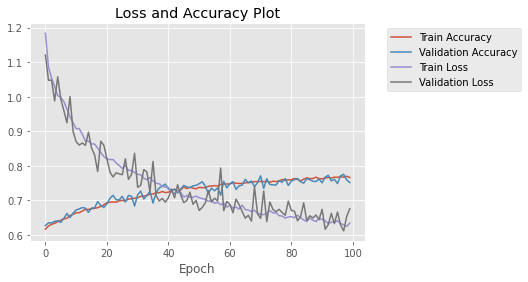

In [ ]:
effnetb4 = keras.models.load_model("../input/effnetb4/EffNetB4.h5")
sdvgg = keras.models.load_model('../input/sgvgg-model/sdvgg.h5')

In [ ]:
# Make sure to save the model you trained to /kaggle/working! 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import smart_resize
## Load model. Use "load_weights" if you only save your model weights.
effnetb4 = keras.models.load_model("../input/effnetb4/EffNetB4.h5")

preds = []
sample_sub = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv')

for image in sample_sub.image_id:
    img = keras.preprocessing.image.load_img('/kaggle/input/cassava-leaf-disease-classification/test_images/' + image)
    img = img_to_array(img)
    img = smart_resize(img, (96,96))
    img = tf.reshape(img, (-1, 96, 96, 3))
    
    # Now apply your model and save your prediction:
    prediction = sdvgg.predict(img)
    preds.append(np.argmax(prediction))
    

my_submission = pd.DataFrame({'image_id': sample_sub.image_id, 'label': preds})
my_submission.to_csv('/kaggle/working/submission.csv', index=False)

In [ ]:
submission=pd.read_csv("./submission.csv")
submission